# SimplePong DQN Training Notebook

This notebook trains a small DQN on a lightweight Pong-like environment (`SimplePongEnv`) that uses numeric observations and Pillow rendering. It is designed to run locally with minimal dependencies. If `torch` is not installed the notebook will fallback to a random policy for demonstration.

**Contents**:

1. Environment definition (Pillow)
2. Simple DQN agent (MLP)
3. Training loop with replay
4. Reward plotting
5. Evaluation and MP4 recording


## 0. Install required packages

Run the following once in your environment if you don't have the packages already:

```bash
pip install pillow numpy matplotlib imageio imageio-ffmpeg torch
```

If you can't install `torch`, the notebook will still run demonstrations using a random policy (no training).

In [1]:
# 1. Environment: SimplePongEnv (Pillow renderer)
from gymnasium import spaces, Env
import numpy as np
import random
from PIL import Image, ImageDraw, ImageFont

class SimplePongEnv(Env):
    """Numeric Simple Pong environment with Pillow rendering."""
    metadata = {"render_modes": ["rgb_array"], "render_fps": 30}

    def __init__(self, render_mode="rgb_array", seed=1):
        super().__init__()
        self.render_mode = render_mode
        self.seed = seed

        # Screen size
        self.WIDTH = 600
        self.HEIGHT = 400

        # Physics objects
        self.BALL_RADIUS = 8
        self.PADDLE_WIDTH = 14
        self.PADDLE_HEIGHT = 90

        # Action/Obs space
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -0.05, -0.05, 0, 0], dtype=np.float32),
            high=np.array([1, 1,  0.05,  0.05, 1, 1], dtype=np.float32),
            dtype=np.float32
        )

        # Load font safely
        try:
            self.font = ImageFont.truetype("arial.ttf", 24)
        except:
            self.font = ImageFont.load_default()

        self.reset(seed=self.seed)

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.seed = seed

        random.seed(self.seed)
        np.random.seed(self.seed)

        # Initialize persistent ball and paddles
        self.ball = np.array([0.5, 0.5,
                              random.choice([-0.012, 0.012]),
                              random.choice([-0.01, 0.01])], dtype=np.float32)
        self.paddle_left = 0.5
        self.paddle_right = 0.5
        self.score = 0
        self.done = False

        return self._get_obs(), {}

    def _get_obs(self):
        return np.array([
            self.ball[0],
            self.ball[1],
            self.ball[2],
            self.ball[3],
            self.paddle_left,
            self.paddle_right
        ], dtype=np.float32)

    def step(self, action):
        # Move left paddle from agent
        if action == 1:  # up
            self.paddle_left = min(1.0, self.paddle_left + 0.025)
        elif action == 2:  # down
            self.paddle_left = max(0.0, self.paddle_left - 0.025)

        # Ball physics update
        self.ball[0] += self.ball[2]
        self.ball[1] += self.ball[3]

        # Wall bounce (top/bottom)
        if self.ball[1] <= 0 or self.ball[1] >= 1:
            self.ball[1] = float(np.clip(self.ball[1], 0.0, 1.0))
            self.ball[3] *= -1

        # Smooth opponent paddle tracking with inertia (no teleport)
        self.paddle_right += 0.08 * (self.ball[1] - self.paddle_right)
        self.paddle_right = float(np.clip(self.paddle_right, 0.0, 1.0))

        reward = 0.0

        # Paddle collision (left)
        if self.ball[0] <= 0.06:
            if abs(self.ball[1] - self.paddle_left) < 0.15:
                self.ball[2] *= -1.02
                self.ball[0] = 0.065
                reward = 1.0
                self.score += 1
            else:
                reward = -1.0
                self.done = True

        # Ball exit right (miss)
        if self.ball[0] >= 0.95:
            reward = -1.0
            self.done = True

        # Clamp speed every step for smooth visuals and to avoid glitches
        self.ball[2] = float(np.clip(self.ball[2], -0.02, 0.02))
        self.ball[3] = float(np.clip(self.ball[3], -0.015, 0.015))

        return self._get_obs(), reward, self.done, False, {"score": self.score}

    def render(self):
        if self.render_mode != "rgb_array":
            return None

        img = Image.new("RGB", (self.WIDTH, self.HEIGHT), (0, 0, 0))
        draw = ImageDraw.Draw(img)

        # Normalized -> pixel positions
        bx = int(self.ball[0] * (self.WIDTH - 50) + 25)
        by = int(self.ball[1] * (self.HEIGHT - 50) + 25)

        # Draw ball
        draw.ellipse((bx - self.BALL_RADIUS, by - self.BALL_RADIUS,
                      bx + self.BALL_RADIUS, by + self.BALL_RADIUS),
                     fill=(255,255,255))

        # Draw paddles
        ly = int(self.paddle_left  * (self.HEIGHT - self.PADDLE_HEIGHT - 20) + 10)
        ry = int(self.paddle_right * (self.HEIGHT - self.PADDLE_HEIGHT - 20) + 10)

        draw.rectangle((5, ly, 5 + self.PADDLE_WIDTH, ly + self.PADDLE_HEIGHT), fill=(255,255,255))
        draw.rectangle((self.WIDTH - 5 - self.PADDLE_WIDTH, ry,
                        self.WIDTH - 5, ry + self.PADDLE_HEIGHT), fill=(255,255,255))

        # Score text
        draw.text((self.WIDTH//2 - 55, 8), f"Score: {self.score}", font=self.font, fill=(255,255,255))

        # Center line
        for y in range(0, self.HEIGHT, 20):
            draw.rectangle((self.WIDTH//2 - 1, y+5, self.WIDTH//2 + 1, y+15), fill=(100,100,100))

        return np.array(img, dtype=np.uint8)


In [2]:
# 2. Simple DQN agent (MLP) + replay buffer
import collections
import random
import numpy as np

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    TORCH_AVAILABLE = True
except Exception as e:
    print('Torch not available; will use random policy. Exception:', e)
    TORCH_AVAILABLE = False

if TORCH_AVAILABLE:
    class MLP(nn.Module):
        def __init__(self, input_dim, n_actions):
            super().__init__()
            self.fc1 = nn.Linear(input_dim, 128)
            self.fc2 = nn.Linear(128, 128)
            self.head = nn.Linear(128, n_actions)
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.head(x)

    class ReplayBuffer:
        def __init__(self, capacity):
            self.buffer = collections.deque(maxlen=capacity)
        def push(self, s,a,r,ns,d):
            self.buffer.append((s,a,r,ns,d))
        def sample(self, batch_size):
            batch = random.sample(self.buffer, batch_size)
            s,a,r,ns,d = map(np.array, zip(*batch))
            return s, a, r, ns, d
        def __len__(self):
            return len(self.buffer)

    class DQNAgent:
        def __init__(self, obs_dim, n_actions, device=None):
            self.device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
            self.net = MLP(obs_dim, n_actions).to(self.device)
            self.target = MLP(obs_dim, n_actions).to(self.device)
            self.target.load_state_dict(self.net.state_dict())
            self.opt = optim.Adam(self.net.parameters(), lr=1e-3)
            self.replay = ReplayBuffer(20000)
            self.n_actions = n_actions
            self.gamma = 0.99
            self.batch_size = 64
            self.update_every = 4
            self.step_count = 0

        def act(self, state, eps=0.0):
            if random.random() < eps:
                return random.randrange(self.n_actions)
            s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q = self.net(s)
            return int(q.argmax(dim=1).item())

        def store(self, s,a,r,ns,d):
            self.replay.push(s,a,r,ns,d)

        def update(self):
            if len(self.replay) < self.batch_size:
                return None
            s,a,r,ns,d = self.replay.sample(self.batch_size)
            s_v = torch.tensor(s, dtype=torch.float32, device=self.device)
            ns_v = torch.tensor(ns, dtype=torch.float32, device=self.device)
            a_v = torch.tensor(a, dtype=torch.int64, device=self.device).unsqueeze(1)
            r_v = torch.tensor(r, dtype=torch.float32, device=self.device)
            d_v = torch.tensor(d.astype(np.uint8), dtype=torch.float32, device=self.device)

            q_vals = self.net(s_v).gather(1, a_v).squeeze(1)
            with torch.no_grad():
                next_actions = self.net(ns_v).argmax(dim=1, keepdim=True)
                next_q = self.target(ns_v).gather(1, next_actions).squeeze(1)
                expected = r_v + (1.0 - d_v) * self.gamma * next_q

            loss = F.mse_loss(q_vals, expected)
            self.opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.net.parameters(), 10.0)
            self.opt.step()
            return float(loss)

        def sync_target(self):
            self.target.load_state_dict(self.net.state_dict())


C:\Users\matty\AppData\Local\Temp\ipykernel_22780\3012799733.py:86: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  return float(loss)


Ep 10/250 R:-1.0 Avg20:-0.90 Steps:447 Time:0.3s
Ep 20/250 R:-1.0 Avg20:-0.95 Steps:822 Time:0.5s
Ep 30/250 R:-1.0 Avg20:-0.95 Steps:1269 Time:0.8s
Ep 40/250 R:-1.0 Avg20:-0.85 Steps:1790 Time:1.2s
Ep 50/250 R:-1.0 Avg20:-0.85 Steps:2239 Time:1.5s
Ep 60/250 R:-1.0 Avg20:-0.90 Steps:2684 Time:1.8s
Ep 70/250 R:0.0 Avg20:-0.80 Steps:3279 Time:2.2s
Ep 80/250 R:0.0 Avg20:-0.70 Steps:3873 Time:2.7s
Ep 90/250 R:-1.0 Avg20:-0.70 Steps:4467 Time:3.1s
Ep 100/250 R:-1.0 Avg20:-0.70 Steps:5061 Time:3.5s
Ep 110/250 R:-1.0 Avg20:-0.75 Steps:5581 Time:4.0s
Ep 120/250 R:-1.0 Avg20:-0.80 Steps:6102 Time:4.4s
Ep 130/250 R:-1.0 Avg20:-0.65 Steps:6839 Time:4.9s
Ep 140/250 R:0.0 Avg20:-0.65 Steps:7362 Time:5.3s
Ep 150/250 R:0.0 Avg20:-0.65 Steps:8101 Time:6.0s
Ep 160/250 R:-1.0 Avg20:-0.65 Steps:8625 Time:6.4s
Ep 170/250 R:-1.0 Avg20:-0.60 Steps:9435 Time:7.1s
Ep 180/250 R:0.0 Avg20:-0.60 Steps:9956 Time:7.6s
Ep 190/250 R:-1.0 Avg20:-0.65 Steps:10696 Time:8.3s
Ep 200/250 R:-1.0 Avg20:-0.50 Steps:11435 Time

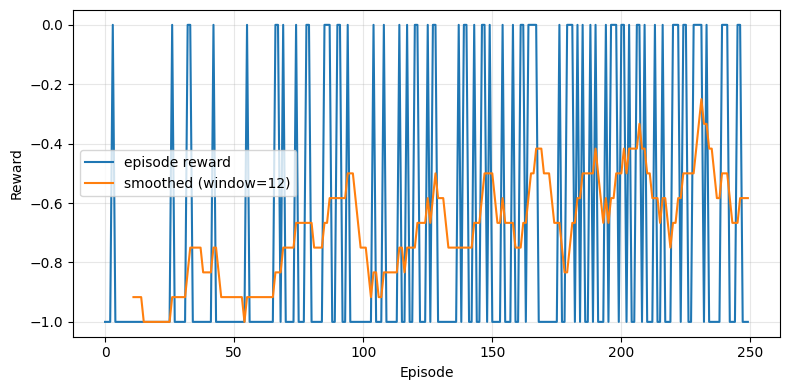

In [3]:
# 3. Training loop (or demo if torch missing)
import time
import matplotlib.pyplot as plt
import os

env = SimplePongEnv(render_mode="rgb_array")
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

if not TORCH_AVAILABLE:
    print("Torch missing — running a short random-policy demo instead.")
    episodes = 10
    rewards = []
    for ep in range(episodes):
        state, _ = env.reset(seed=ep)
        done = False
        ep_r = 0.0
        while not done:
            action = env.action_space.sample()
            state, r, done, _, info = env.step(action)
            ep_r += r
        rewards.append(ep_r)
    print("Demo rewards:", rewards)
else:
    agent = DQNAgent(obs_dim, n_actions)
    eps_start = 1.0
    eps_end = 0.05
    eps_decay = 5000
    episodes = 250
    rewards = []
    losses = []
    start_time = time.time()
    total_steps = 0

    for ep in range(episodes):
        state, _ = env.reset(seed=ep)
        done = False
        ep_r = 0.0
        while not done:
            eps = max(eps_end, eps_start - total_steps/eps_decay)
            action = agent.act(state, eps=eps)
            next_state, r, done, _, info = env.step(action)
            agent.store(state, action, r, next_state, done)
            state = next_state
            ep_r += r

            # learning step
            agent.step_count += 1
            if agent.step_count % agent.update_every == 0:
                loss = agent.update()
                if loss is not None:
                    losses.append(loss)

            total_steps += 1

        rewards.append(ep_r)
        if ep % 10 == 0:
            agent.sync_target()
        if (ep+1) % 10 == 0:
            avg20 = sum(rewards[-20:])/min(len(rewards),20)
            elapsed = time.time() - start_time
            print(f"Ep {ep+1}/{episodes} R:{ep_r:.1f} Avg20:{avg20:.2f} Steps:{total_steps} Time:{elapsed:.1f}s")

    # save model
    model_path = "dqn_simplepong.pth"
    torch.save(agent.net.state_dict(), model_path)
    print("Training finished. Model saved to", model_path)

# Plot rewards (works for demo or training)
plt.figure(figsize=(8,4))
plt.plot(rewards, label="episode reward")
if len(rewards) >= 10:
    window = max(5, len(rewards)//20)
    smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, window-1+len(smooth)), smooth, label=f"smoothed (window={window})")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("training_rewards.png", dpi=150)
print("Saved training_rewards.png")


In [4]:
# 4. Continuous Evaluation + 15-second GIF Recording (no resets, no flashing, no glitches)
import numpy as np
from PIL import Image

env = SimplePongEnv(render_mode="rgb_array")
state, _ = env.reset(seed=999)

frames = []
total_reward = 0.0

fps = 30
duration_seconds = 15
target_frames = fps * duration_seconds  # 450 frames

agent_loaded = False
if TORCH_AVAILABLE:
    try:
        agent = DQNAgent(obs_dim, n_actions)
        agent.net.load_state_dict(torch.load("dqn_simplepong.pth", map_location=agent.device))
        agent_loaded = True
        print("Loaded trained agent.")
    except Exception as e:
        print("Could not load agent, using random policy:", e)

# Collect 15 seconds worth of frames
for t in range(target_frames):
    action = agent.act(state, eps=0.0) if agent_loaded else env.action_space.sample()
    state, reward, done, _, info = env.step(action)
    total_reward += reward

    frame = env.render()
    frames.append(Image.fromarray(frame))

    if done:
        break

env.close()
print("Eval reward:", total_reward, "frames:", len(frames))

# Pad with the final frame if environment ended before 450 frames
while len(frames) < target_frames:
    frames.append(frames[-1])

# Save GIF smoothly using Pillow
gif_path = "pong_eval_15s.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:target_frames],
    duration=int(1000/fps),
    loop=0,
    optimize=False,  # prevents compression artifacts/glitching
    disposal=2       # prevents frame-stack ghosting
)

print("✅ Saved 15-second GIF to", gif_path)


Loaded trained agent.
Eval reward: 0.0 frames: 110
✅ Saved 15-second GIF to pong_eval_15s.gif


## Notes

- If you run into issues installing `torch`, the notebook will still function for demos using a random policy.
- For real training, a GPU helps but this small MLP runs on CPU as well. Adjust the number of episodes and hyperparameters to suit your machine.
- I can modify this notebook to use a CNN with pixel observations if you want to switch from numeric state to vision-based DQN.
